# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

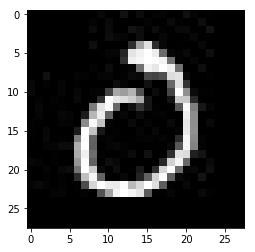

In [2]:
show_n_images = 2

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

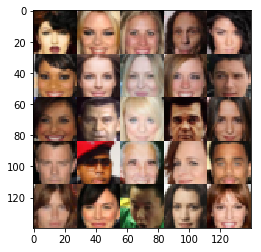

In [3]:
show_n_images = 28

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return (input_real, input_z, in_learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [13]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        # 14x14x32
        
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batch_normalization2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * batch_normalization2, batch_normalization2)
        # 7x7x128
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batch_normalization3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * batch_normalization3, batch_normalization3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        outputs = tf.sigmoid(logits)
        
        return (outputs, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        layer1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        layer1 = tf.reshape(layer1, (-1, 2, 2, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        # 4x4x512 now
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        # 16x16x256 now
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        #logits = tf.slice(logits, [0, 2, 2, 0], [-1, 28, 28, -1])
        output = tf.tanh(logits)
        
        return (output)
        



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return (dis_train_ops, gen_train_ops)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    print_every = 20
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.5311... Generator Loss: 1.9702
Epoch 0/2... Discriminator Loss: 1.3657... Generator Loss: 0.6097
Epoch 0/2... Discriminator Loss: 0.4912... Generator Loss: 2.1603
Epoch 0/2... Discriminator Loss: 0.4453... Generator Loss: 3.0238


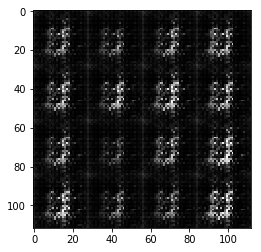

Epoch 0/2... Discriminator Loss: 0.4085... Generator Loss: 6.9707
Epoch 0/2... Discriminator Loss: 0.5137... Generator Loss: 3.1310
Epoch 0/2... Discriminator Loss: 0.5082... Generator Loss: 2.7932
Epoch 0/2... Discriminator Loss: 0.4734... Generator Loss: 2.5033
Epoch 0/2... Discriminator Loss: 0.5033... Generator Loss: 2.6470


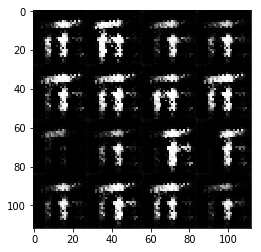

Epoch 0/2... Discriminator Loss: 0.4059... Generator Loss: 4.1645
Epoch 0/2... Discriminator Loss: 0.3799... Generator Loss: 4.0830
Epoch 0/2... Discriminator Loss: 0.4293... Generator Loss: 3.9072
Epoch 0/2... Discriminator Loss: 0.5973... Generator Loss: 2.3924
Epoch 0/2... Discriminator Loss: 0.5895... Generator Loss: 2.0008


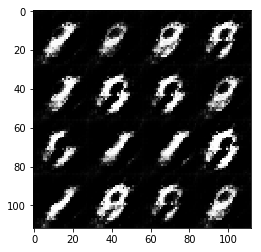

Epoch 0/2... Discriminator Loss: 0.7521... Generator Loss: 5.5117
Epoch 0/2... Discriminator Loss: 0.4270... Generator Loss: 3.0304
Epoch 0/2... Discriminator Loss: 0.4169... Generator Loss: 4.2382
Epoch 0/2... Discriminator Loss: 0.4705... Generator Loss: 3.2316
Epoch 0/2... Discriminator Loss: 0.4241... Generator Loss: 2.9338


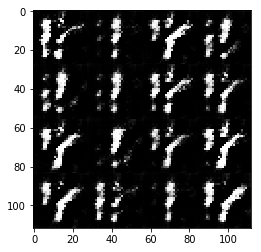

Epoch 0/2... Discriminator Loss: 0.5031... Generator Loss: 3.3038
Epoch 0/2... Discriminator Loss: 0.4079... Generator Loss: 3.7923
Epoch 0/2... Discriminator Loss: 0.5089... Generator Loss: 2.7382
Epoch 0/2... Discriminator Loss: 0.4577... Generator Loss: 3.1918
Epoch 0/2... Discriminator Loss: 0.5355... Generator Loss: 3.5714


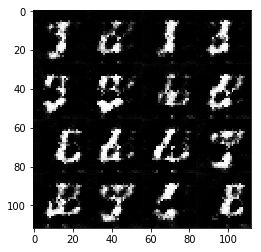

Epoch 0/2... Discriminator Loss: 0.4570... Generator Loss: 3.6231
Epoch 0/2... Discriminator Loss: 0.4684... Generator Loss: 3.2510
Epoch 0/2... Discriminator Loss: 0.5370... Generator Loss: 2.3738
Epoch 0/2... Discriminator Loss: 0.6073... Generator Loss: 1.9769
Epoch 0/2... Discriminator Loss: 0.6659... Generator Loss: 2.7123


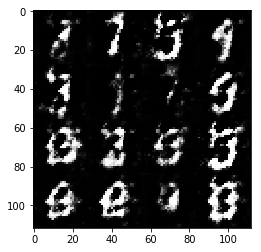

Epoch 0/2... Discriminator Loss: 0.6294... Generator Loss: 2.2915
Epoch 0/2... Discriminator Loss: 0.5392... Generator Loss: 2.2370
Epoch 0/2... Discriminator Loss: 0.8771... Generator Loss: 1.1780
Epoch 0/2... Discriminator Loss: 0.6514... Generator Loss: 2.7275
Epoch 0/2... Discriminator Loss: 1.0161... Generator Loss: 1.7123


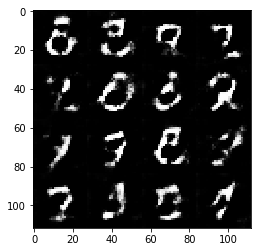

Epoch 0/2... Discriminator Loss: 0.7531... Generator Loss: 1.7351
Epoch 0/2... Discriminator Loss: 1.4659... Generator Loss: 4.1419
Epoch 0/2... Discriminator Loss: 0.6251... Generator Loss: 1.8471
Epoch 0/2... Discriminator Loss: 0.8989... Generator Loss: 1.1127
Epoch 0/2... Discriminator Loss: 0.7573... Generator Loss: 2.1705


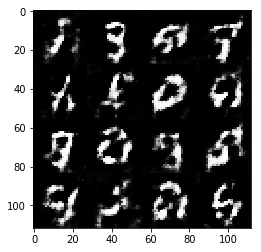

Epoch 0/2... Discriminator Loss: 0.6657... Generator Loss: 2.3825
Epoch 0/2... Discriminator Loss: 0.6896... Generator Loss: 1.7589
Epoch 0/2... Discriminator Loss: 0.7500... Generator Loss: 1.4765
Epoch 0/2... Discriminator Loss: 0.7913... Generator Loss: 2.5877
Epoch 0/2... Discriminator Loss: 0.7313... Generator Loss: 1.8333


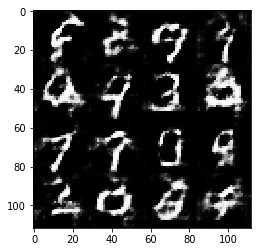

Epoch 0/2... Discriminator Loss: 0.8644... Generator Loss: 2.0478
Epoch 0/2... Discriminator Loss: 0.6625... Generator Loss: 1.6572
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 2.0671
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 1.8691
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.4786


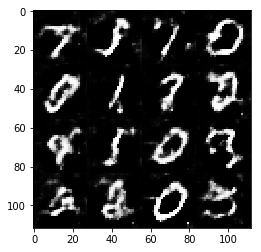

Epoch 1/2... Discriminator Loss: 0.7050... Generator Loss: 2.2255
Epoch 1/2... Discriminator Loss: 0.7951... Generator Loss: 1.3358
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 1.4652
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 1.8869
Epoch 1/2... Discriminator Loss: 0.8189... Generator Loss: 1.2706


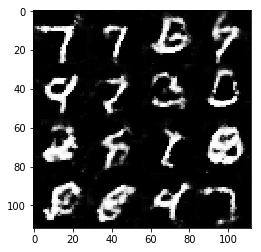

Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 1.7893
Epoch 1/2... Discriminator Loss: 0.7789... Generator Loss: 1.9064
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.5422
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 1.5541
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 1.0811


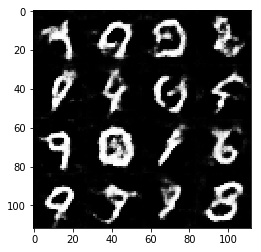

Epoch 1/2... Discriminator Loss: 0.8380... Generator Loss: 1.2327
Epoch 1/2... Discriminator Loss: 0.7954... Generator Loss: 1.3419
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 1.2673
Epoch 1/2... Discriminator Loss: 0.8166... Generator Loss: 1.2656
Epoch 1/2... Discriminator Loss: 0.8749... Generator Loss: 1.2932


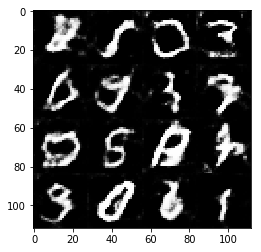

Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 1.1985
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.6409
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 1.7033
Epoch 1/2... Discriminator Loss: 0.7872... Generator Loss: 1.4024


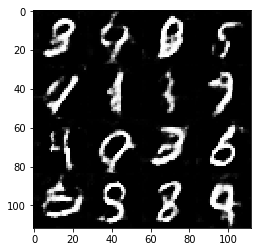

Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 2.3387
Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.1702
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 2.2747
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 2.0271
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 1.1459


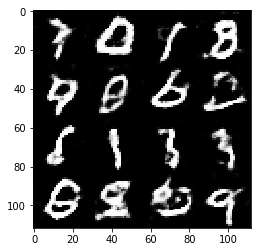

Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 1.1102
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 0.7371... Generator Loss: 1.3165
Epoch 1/2... Discriminator Loss: 0.7425... Generator Loss: 1.8362
Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 1.4854


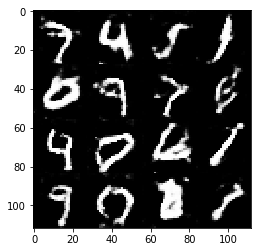

Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 1.1769
Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 1.7669
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.7148
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.6586
Epoch 1/2... Discriminator Loss: 0.7318... Generator Loss: 1.6798


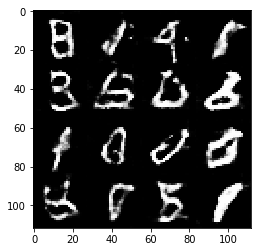

Epoch 1/2... Discriminator Loss: 0.8290... Generator Loss: 1.0656
Epoch 1/2... Discriminator Loss: 0.7935... Generator Loss: 1.7637
Epoch 1/2... Discriminator Loss: 0.7359... Generator Loss: 1.6787
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 1.3415
Epoch 1/2... Discriminator Loss: 0.6566... Generator Loss: 1.8977


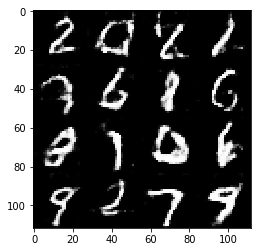

Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.1737
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 1.5310


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.5676... Generator Loss: 2.5275
Epoch 0/1... Discriminator Loss: 0.4304... Generator Loss: 3.7741
Epoch 0/1... Discriminator Loss: 0.4846... Generator Loss: 2.4424
Epoch 0/1... Discriminator Loss: 0.5909... Generator Loss: 3.4751


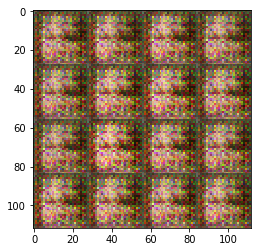

Epoch 0/1... Discriminator Loss: 0.5081... Generator Loss: 2.3866
Epoch 0/1... Discriminator Loss: 0.4314... Generator Loss: 3.1780
Epoch 0/1... Discriminator Loss: 0.4221... Generator Loss: 3.2505
Epoch 0/1... Discriminator Loss: 0.4221... Generator Loss: 3.4468
Epoch 0/1... Discriminator Loss: 0.4547... Generator Loss: 6.4982


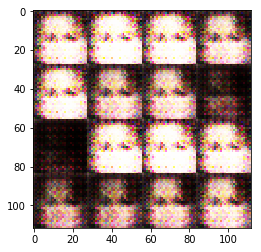

Epoch 0/1... Discriminator Loss: 0.6255... Generator Loss: 3.3260
Epoch 0/1... Discriminator Loss: 0.5889... Generator Loss: 1.8421
Epoch 0/1... Discriminator Loss: 0.5091... Generator Loss: 2.3586
Epoch 0/1... Discriminator Loss: 0.5144... Generator Loss: 2.2122
Epoch 0/1... Discriminator Loss: 0.6859... Generator Loss: 2.3445


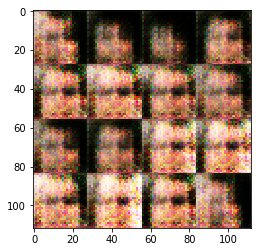

Epoch 0/1... Discriminator Loss: 0.6198... Generator Loss: 2.5616
Epoch 0/1... Discriminator Loss: 1.0128... Generator Loss: 0.9085
Epoch 0/1... Discriminator Loss: 0.7774... Generator Loss: 1.4628
Epoch 0/1... Discriminator Loss: 1.0845... Generator Loss: 2.8297
Epoch 0/1... Discriminator Loss: 0.7543... Generator Loss: 1.5393


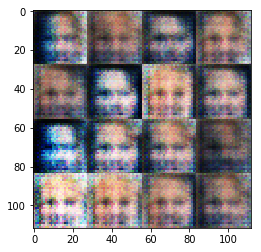

Epoch 0/1... Discriminator Loss: 0.7671... Generator Loss: 1.9223
Epoch 0/1... Discriminator Loss: 0.6965... Generator Loss: 1.8103
Epoch 0/1... Discriminator Loss: 1.6668... Generator Loss: 4.8987
Epoch 0/1... Discriminator Loss: 0.9248... Generator Loss: 1.8706
Epoch 0/1... Discriminator Loss: 0.8617... Generator Loss: 1.1905


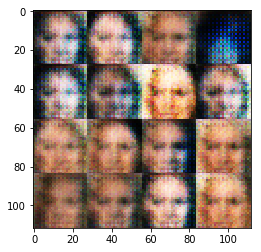

Epoch 0/1... Discriminator Loss: 0.7701... Generator Loss: 2.2497
Epoch 0/1... Discriminator Loss: 1.0073... Generator Loss: 1.4214
Epoch 0/1... Discriminator Loss: 1.0831... Generator Loss: 1.6139
Epoch 0/1... Discriminator Loss: 0.9993... Generator Loss: 1.0604
Epoch 0/1... Discriminator Loss: 1.0743... Generator Loss: 1.3232


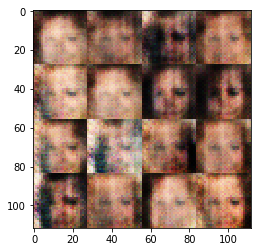

Epoch 0/1... Discriminator Loss: 1.0824... Generator Loss: 1.4689
Epoch 0/1... Discriminator Loss: 1.1238... Generator Loss: 1.2563
Epoch 0/1... Discriminator Loss: 0.9453... Generator Loss: 1.4083
Epoch 0/1... Discriminator Loss: 1.1759... Generator Loss: 1.8650
Epoch 0/1... Discriminator Loss: 1.6246... Generator Loss: 0.4821


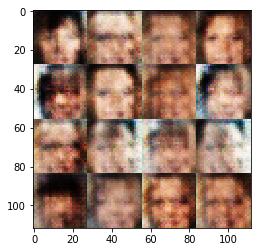

Epoch 0/1... Discriminator Loss: 1.0551... Generator Loss: 2.1743
Epoch 0/1... Discriminator Loss: 1.0952... Generator Loss: 0.9650
Epoch 0/1... Discriminator Loss: 1.1468... Generator Loss: 0.8039
Epoch 0/1... Discriminator Loss: 0.9269... Generator Loss: 1.3408
Epoch 0/1... Discriminator Loss: 1.1620... Generator Loss: 1.9697


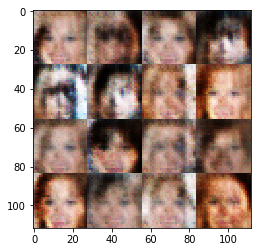

Epoch 0/1... Discriminator Loss: 1.0630... Generator Loss: 1.8310
Epoch 0/1... Discriminator Loss: 0.8778... Generator Loss: 1.5568
Epoch 0/1... Discriminator Loss: 1.1253... Generator Loss: 1.5735
Epoch 0/1... Discriminator Loss: 1.0961... Generator Loss: 1.9326
Epoch 0/1... Discriminator Loss: 1.0244... Generator Loss: 1.0649


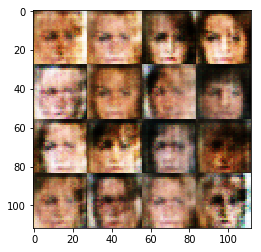

Epoch 0/1... Discriminator Loss: 1.1960... Generator Loss: 1.8677
Epoch 0/1... Discriminator Loss: 1.4523... Generator Loss: 0.6226
Epoch 0/1... Discriminator Loss: 1.1805... Generator Loss: 0.8672
Epoch 0/1... Discriminator Loss: 1.0196... Generator Loss: 0.9982
Epoch 0/1... Discriminator Loss: 0.9204... Generator Loss: 1.2708


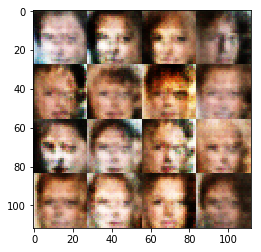

Epoch 0/1... Discriminator Loss: 1.0026... Generator Loss: 1.5955
Epoch 0/1... Discriminator Loss: 0.9246... Generator Loss: 1.6297
Epoch 0/1... Discriminator Loss: 1.1759... Generator Loss: 1.9780
Epoch 0/1... Discriminator Loss: 0.9927... Generator Loss: 1.5478
Epoch 0/1... Discriminator Loss: 1.1378... Generator Loss: 0.8125


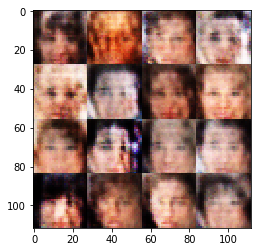

Epoch 0/1... Discriminator Loss: 0.8780... Generator Loss: 1.4069
Epoch 0/1... Discriminator Loss: 1.0277... Generator Loss: 2.4883
Epoch 0/1... Discriminator Loss: 1.0162... Generator Loss: 0.9997
Epoch 0/1... Discriminator Loss: 1.0193... Generator Loss: 1.8254
Epoch 0/1... Discriminator Loss: 1.4624... Generator Loss: 0.5271


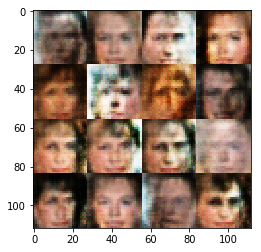

Epoch 0/1... Discriminator Loss: 0.9645... Generator Loss: 1.2480
Epoch 0/1... Discriminator Loss: 1.0055... Generator Loss: 1.1449
Epoch 0/1... Discriminator Loss: 0.9419... Generator Loss: 1.3587
Epoch 0/1... Discriminator Loss: 1.2563... Generator Loss: 0.7572
Epoch 0/1... Discriminator Loss: 1.1019... Generator Loss: 1.3142


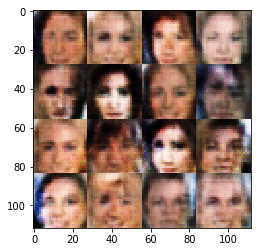

Epoch 0/1... Discriminator Loss: 0.9653... Generator Loss: 1.0467
Epoch 0/1... Discriminator Loss: 0.8852... Generator Loss: 1.3882
Epoch 0/1... Discriminator Loss: 1.0570... Generator Loss: 1.5589
Epoch 0/1... Discriminator Loss: 1.1589... Generator Loss: 0.8610
Epoch 0/1... Discriminator Loss: 0.8545... Generator Loss: 1.8821


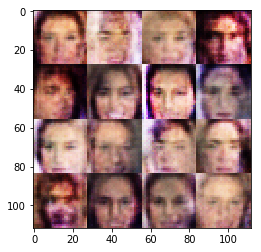

Epoch 0/1... Discriminator Loss: 1.0974... Generator Loss: 0.9231
Epoch 0/1... Discriminator Loss: 1.1434... Generator Loss: 1.5852
Epoch 0/1... Discriminator Loss: 1.1004... Generator Loss: 1.3342
Epoch 0/1... Discriminator Loss: 1.1775... Generator Loss: 1.8699
Epoch 0/1... Discriminator Loss: 0.9970... Generator Loss: 1.0473


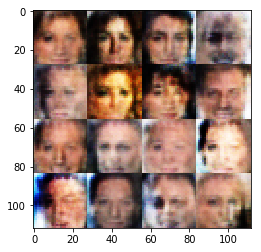

Epoch 0/1... Discriminator Loss: 0.9543... Generator Loss: 1.3801
Epoch 0/1... Discriminator Loss: 1.1275... Generator Loss: 1.5178
Epoch 0/1... Discriminator Loss: 1.2727... Generator Loss: 0.6375
Epoch 0/1... Discriminator Loss: 0.8796... Generator Loss: 1.4001
Epoch 0/1... Discriminator Loss: 0.9740... Generator Loss: 1.4994


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.